<center><h1> Rapport Base de données</h1></center>
<center><h2>Kenza HATEM</h2></center>
<center><i><b>NE :</b>12206971</i></center>
<br>
<center><img src="https://media.licdn.com/dms/image/v2/D5612AQHvX3Ftp9DLlQ/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1722349221203?e=2147483647&v=beta&t=W1PXm4d6ueeRKqpgg_T0MQAUftcl1D-xEDLWMycyRR4"></center>


# Cas pratique : Quizz Constructif
![](https://phpscriptsmall.com/wp-content/uploads/2019/06/online-quiz-1.jpg)

## Description du Projet
Le projet "Quizz Constructif" est une application de quizz en temps réel, où les utilisateurs participent de manière simultanée et peuvent s’aider mutuellement via un chat contrôlé. Le système doit permettre une réponse rapide aux actions des utilisateurs pour assurer une expérience interactive et fluide.

## Spécifications Fonctionnelles
- **Lancement Simultané du Quizz** : Toutes les questions seront lancées en même temps pour les utilisateurs connectés.
- **Gestion des Pseudos** : Chaque utilisateur peut choisir un pseudo à la connexion, sinon un pseudo par défaut (ex. `user1`, `user2`, etc.) est attribué.
- **Limite d'Utilisateurs** : Maximum de 30 utilisateurs connectés simultanément.
- **Questions à Choix Multiples** : Les questions sont de type QCM (A, B, C, ...).
- **Canal de Chat Filtré** : Un canal de chat permet aux utilisateurs d'échanger des indices, mais bloque les réponses directes aux questions.

## Détails Supplémentaires

- **Sessions Temporaires** : Les utilisateurs et leurs données sont temporaires et sont détruits après chaque session de quizz, ce qui limite la persistance en mémoire. Redis se prête bien à ce besoin car il gère facilement des données temporaires en mémoire.
- **Renouvellement du Quizz** : Les questions du quizz sont régénérées et mises à jour à chaque nouvelle session. Cela signifie que chaque connexion peut potentiellement présenter un nouveau jeu de questions, garantissant une expérience renouvelée pour chaque session.

## Choix Technologique : Redis
### Pourquoi on devrait éviter d'utiliser une BDD SQL : 
 - Les bases de données SQL sont conçues pour des données persistantes, alors que dans ce cas pratique les données sont temporaires.
 - L'écriture et la lecture rapide est crucial pour notre projet ce qui n'est pas la priorité d'une base de données SQL.

### Avantages de Redis pour ce Projet

1. **Temps Réel et Communication Instantanée**
   - Redis propose une **fonction de publication/souscription (Pub/Sub)** native. Cela permet d'envoyer instantanément les messages de chat entre les utilisateurs connectés, sans délai. Cette communication instantanée est essentielle pour un jeu en temps réel.
   
2. **Gestion de Données Temporaires et Légères**
   - Redis utilise la **mémoire RAM** pour stocker les données, ce qui permet des lectures et écritures rapides. La suppression des utilisateurs à la fin de chaque session limite la quantité de mémoire utilisée.
   - Pour une limite de 30 utilisateurs, Redis est plus que suffisant. De plus, la suppression des utilisateurs après chaque session optimise l'utilisation de la RAM et assure des performances constantes.

3. **Stockage et Régénération des Questions de Quizz**
   - Les questions du quizz peuvent être stockées temporairement dans Redis avec une **date d'expiration** ou un rafraîchissement des données pour chaque nouvelle session.(à confirmer avec le client )
   - Redis supporte également des structures de données comme les **hashes et les sets**, qui facilitent le stockage structuré des questions, des réponses, et des scores des utilisateurs.

4. **Scalabilité et Limitation des Ressources**
   - Redis est conçu pour supporter un grand nombre de connexions simultanées, ce qui est idéal même pour une extension de notre application à plus de 30 utilisateurs.

### Inconvénients de MongoDB pour ce cas

1. **Absence de Communication en Temps Réel**
   - MongoDB n'a pas de mécanisme Pub/Sub natif, ce qui rendrait difficile la gestion d’un chat en temps réel avec filtres.

2. **Adaptation Moins Flexible aux Données Temporaires**
   - MongoDB est orienté vers des données plus permanentes. Pour des données temporaires, MongoDB serait plus coûteux et moins performant que Redis, surtout dans le cas d’utilisateurs supprimés après chaque session et de questions renouvelées.


## Extension Potentielle : Stockage des Données Utilisateur 
(Cela dépendera de la demande du client)

Si un stockage persistant des données utilisateur était nécessaire, on pourrait combiner MongoDB et Redis (comme illusté ci-dessous un exemple d'une application):

- **MongoDB** : Pour stocker durablement les informations utilisateur et les résultats de quizz, MongoDB offrirait une gestion efficace des données structurées et un stockage longue durée.
  
- **Redis en Cache** : Redis servirait à gérer les sessions en temps réel pour garantir rapidité et fluidité des interactions pendant le quizz, en déchargeant MongoDB des données temporaires.

Ainsi, Redis assurerait la réactivité en temps réel, tandis que MongoDB préserverait les données importantes à long terme.

![](https://romankudryashov.com/blog/2021/06/mongodb-redis-rust/images/architecture.png)


## Conclusion
Redis est le choix idéal pour le projet "Quizz Constructif" en raison de sa gestion rapide des données temporaires, de ses capacités de communication en temps réel, et de son efficacité pour stocker les informations liées au quizz et aux utilisateurs.

---

<b>Nous allons aborder plusieurs aspects essentiels dans le développement de ce projet :</b>

## Traitement des questions posées durant le quizz

Les questions pour les quizz seront fournis en deux formats possibles, en `csv` ou en `txt`, qui seront convertis en json afin de les traiter

#### Convertir des fichiers csv en fichier json

In [77]:
#convertir un fichier csv en fichier json
import csv
import json

def csv_to_json(csv_file_path, json_file_path):
    data = {}

    with open(csv_file_path, encoding='utf-8') as csv_file_handler:
        csv_reader = csv.DictReader(csv_file_handler)
        
        for row in csv_reader:
            key = row['ID']
            if key not in data:
                data[key] = []
            data[key].append(row)

    with open(json_file_path, 'w', encoding='utf-8') as json_file_handler:
        json.dump(data, json_file_handler, indent=4, ensure_ascii=False)

csv_to_json("quizz2.csv", "quizz2_new.json")
csv_to_json("quizz.csv", "quizz_new.json")

#### Convertir des fichiers txt en fichier json

In [57]:
import json

def csv_to_json(txt_file, new_file_merged):
    with open(txt_file, 'r', encoding='utf-8') as f:
        content = f.read()
        
    lines = content.split("\n")
    result = {}
    for i, line in enumerate(lines):
        if line.strip():  
            # ignorer la première ligne qui contient les en-têtes
            if i == 0:
                continue
            
            data = line.split('\t')  
            question = {
                'ID': data[0],
                'Question': data[1],
                'Choix A': data[2],
                'Choix B': data[3],
                'Choix C': data[4],
                'Choix D': data[5],
                'Reponse': data[6],
                'Categorie': data[7]
            }
            
            result[data[0]] = [question]  
    with open(new_file_merged, 'w', encoding='utf-8') as json_file:
        json.dump(result, json_file, ensure_ascii=False, indent=4)

csv_to_json("quizz.txt", "quizzFromTxt.json")


Une fois les questions converties en JSON, elles pourront être facilement gérées avec Redis.

# Création des utilisateurs

## Comparaison entre l’utilisation de `hset` et `redis-om` pour la gestion des données d'utilisateurs

## Introduction

Dans le cadre du projet **"Quizz Constructif"**, nous devons gérer des données d'utilisateurs temporaires en utilisant Redis. Ce document explore deux approches possibles pour structurer et manipuler les données d'utilisateur :
1. Utilisation de la commande native Redis `hset`
2. Utilisation de `redis-om`, une bibliothèque Redis permettant de structurer les données en modèles (ORM-like).

L’objectif est de comparer les deux approches en termes de structure, performances, et facilité de maintenance.

## Méthode

### Option 1: Utilisation de `hset`

La méthode `hset` est utilisée pour insérer directement des valeurs clés dans un hash Redis. Dans notre cas, elle pourrait être utilisée pour stocker chaque utilisateur comme suit :

In [62]:
# Fonction pour ajouter un utilisateur avec pseudo et score initial
def add_user(user_id, pseudo):
    r.hset(f"user:{user_id}", "pseudo", pseudo)
    r.hset(f"user:{user_id}", "score", 0)

# Exemple de création d'utilisateurs
add_user(19865, "Alex")
add_user(23269, "John")

# Fonction pour mettre à jour le score d'un utilisateur
def update_score(user_id, score):
    r.hset(f"user:{user_id}", "score", score)

# Exemple de mise à jour de score pour Alex
update_score(19865, 10)

# Fonction pour récupérer les informations d'un utilisateur
def get_user(user_id):
    return r.hgetall(f"user:{user_id}")

# Exemple d'affichage des informations de l'utilisateur Alex
user_info = get_user(19865)
print("User 19865 info:", user_info)

# Fonction pour incrémenter le score d'un utilisateur
def increment_score(user_id, increment=1):
    r.hincrby(f"user:{user_id}", "score", increment)

# Exemple d'incrémentation du score de John
increment_score(23269, 5)

# Récupération et affichage du score de John
print("Updated score for John:", get_user(23269))

# Fonction pour supprimer un utilisateur
def delete_user(user_id):
    r.delete(f"user:{user_id}")

# Suppression de l'utilisateur Alex
delete_user(19865)

# Vérification de la suppression
print("User 19865 exists?", r.exists("user:19865"))

User 19865 info: {'pseudo': 'Alex', 'score': '10'}
Updated score for John: {'pseudo': 'John', 'score': '5'}
User 19865 exists? 0


Chaque utilisateur est enregistré dans un hash avec son pseudo et son score, utilisant comme clé user:`{user_id}`.

### Option 2: Utilisation de redis-om
`redis-om` permet de modéliser les utilisateurs en utilisant des classes Python et gère automatiquement la création et l’accès aux données dans Redis.

Exemple de modèle `redis-om` pour un utilisateur :

In [17]:
import datetime
import dateutil.parser
from typing import List, Optional

from redis_om import (
    JsonModel,
    Field,
    Migrator,
)


class Person2(JsonModel):
    id : int = Field(index=True)
    pseudo : str = Field(index=True)
    verified: bool = Field(index=True)
    personal_statement: Optional[str] = Field(index=True) , 
    score : float = Field(index=True)

Migrator().run()

In [18]:
# Personne 1
person1 = Person2(**{
    "id": 1,
    "pseudo": "Alex",
    "verified": True,
    "personal_statement": "I like video games" , 
    "score" : 0.0
}).save()

# Personne 2
person2 = Person2(**{
    "id": 2,
    "pseudo": "John",
    "verified": True,
    "personal_statement": "" , 
    "score" : 0.0
}).save()

#### Fonctionnalités de Redis-OM


In [20]:
id = person1.pk
person1 = Person2.get(id)

# modify
person1 = Person2.get(id)
person1.pseudo = "user1"

# save les modifications ajoutés 
person1.save()

Person2(pk='01JBSRSQ5300ZA6S8Z5VA1V4HX', id=1, pseudo='user1', verified=True, personal_statement='I like video games', score=0.0)

In [21]:
# Récupérer tous les enregistrements de `Person`
all_people = Person2.find().all()
for person in all_people:
    print(person)  


pk='01JBSQ4NQYA9FCNSSEA8TGJ74W' id=1 pseudo='Alex' verified=True personal_statement='I like video games' score=0.0
pk='01JBSQ4NR4T5QWM3QYKHXT7Q9D' id=2 pseudo='John' verified=True personal_statement='' score=0.0
pk='01JBSRSQ5NF5EC1EBNXY7C1R0C' id=2 pseudo='John' verified=True personal_statement='' score=0.0
pk='01JBSRSQ5300ZA6S8Z5VA1V4HX' id=1 pseudo='user1' verified=True personal_statement='I like video games' score=0.0


In [31]:
import pprint
# Rechercher toutes les personnes avec score > 0 et vérifiées
people_with_score = Person2.find(
    (Person2.score > 0) & (Person2.verified == True)
).all()
pprint.pprint(people)
print("-")

# Rechercher les personnes dont le score est supérieur à 75 ou avec le pseudo "Alex"
people = Person2.find(
    (Person2.score > 75) | (Person2.pseudo == "Alex")
).all()
pprint.pprint(people)
print("-")

# Recherche complexe combinée
people = Person2.find(
    ((Person2.score > 21) & (Person2.pseudo == "Alex")) |
    ((Person2.score > 75) | (Person2.pseudo == "John"))
).all()
pprint.pprint(people)

[Person2(pk='01JBSQ4NR4T5QWM3QYKHXT7Q9D', id=2, pseudo='John', verified=True, personal_statement='', score=0.0),
 Person2(pk='01JBSRSQ5NF5EC1EBNXY7C1R0C', id=2, pseudo='John', verified=True, personal_statement='', score=0.0)]
-
[Person2(pk='01JBSQ4NQYA9FCNSSEA8TGJ74W', id=1, pseudo='Alex', verified=True, personal_statement='I like video games', score=0.0)]
-
[Person2(pk='01JBSQ4NR4T5QWM3QYKHXT7Q9D', id=2, pseudo='John', verified=True, personal_statement='', score=0.0),
 Person2(pk='01JBSRSQ5NF5EC1EBNXY7C1R0C', id=2, pseudo='John', verified=True, personal_statement='', score=0.0)]


In [30]:
# Supprimer tous les utilisateurs une fois la session terminé 
for person  in Person2.find().all() : 
    id = person1.pk
    person.delete(id) 

In [ ]:
# Suppression d'une personne avec un ID spécifique
from redis_om import NotFoundError

try:
    Person2.get(1).delete() 
except NotFoundError:
    print("Person not found")

Person not found


### Discussion :
Pour un projet comme **"Quizz Constructif"** :

`Redis-OM` : Un bon choix si l’application doit évoluer avec des fonctionnalités de recherche, de tri, ou une gestion structurée des utilisateurs (surtout si de nouveaux besoins apparaissent).

`hset` simple : Convient mieux si l’objectif est de rester simple, rapide et éphémère, car Redis gère facilement des hashs pour 30 utilisateurs temporaires sans nécessiter de modèles.

### Conclusion :
Pour ce cas spécifique, où la performance et la simplicité priment et les données sont temporaires, la méthode `hset` est probablement le meilleur choix, car elle est légère et suffit pour les besoins actuels de l’application.
Si des besoins plus complexes sont envisageables, alors Redis OM pourrait être plus bénéfique.

# Les jointures des questions du quizz 

Les questions sont divisés en plusieurs catégories,

        {
            "ID": "1",
            "Question": "Quelle est la capitale de la France ?",
            "Choix A": "Paris",
            "Choix B": "Lyon",
            "Choix C": "Marseille",
            "Choix D": "Toulouse",
            "Reponse": "A",
            "Categorie": "Géographie"
        }
Nous pourront réaliser une jointure entre de fichiers json pour regrouper les questions de la `même catégorie`.


![](https://storage.googleapis.com/sales.appinst.io/2017/05/quiz-app-screenshot-1.png)

## 1- Par boucle imbriquée 

Il s'agit de parcourir les deux fichiers et ajouter les questions de la catégorie donnée.

In [1]:
import json
import collections
from collections import defaultdict

def filter_and_merge_by_category(file1, file2, category):
    with open(file1, "r", encoding='utf-8') as file1, open(file2, "r", encoding='utf-8') as file2:
        data1 = json.load(file1)
        data2 = json.load(file2)
    merged_data = defaultdict(list)

    for data in [data1, data2]:
        for key, questions in data.items():
            for question in questions:
                if question.get("Categorie") == category:
                    merged_data[key].append(question)
    with open(f"{category}_questionsNestedLoop.json", "w") as output_file:
        json.dump(merged_data, output_file, indent=4, ensure_ascii=False)
category = "Astronomie"
filter_and_merge_by_category("quizz_new.json", "quizz2_new.json", category)



Ce type de jointure est simple mais inefficace pour des grandes quantités de données.

## 2- Tri par fusion 

Exécuter une jointure pour fusionner deux fichiers JSON, en triant les données par ID et en combinant les questions en une seule structure

In [3]:
import json
def merge_sort_join(file1, file2, category):
    with open(file1, "r") as file1, open(file2, "r") as file2:
        data1 = json.load(file1)
        data2 = json.load(file2)
 
    filtered_data1 = [q for questions in data1.values() for q in questions if q.get("Categorie") == category]
    filtered_data2 = [q for questions in data2.values() for q in questions if q.get("Categorie") == category]

    # trier
    sorted_data1 = sorted(filtered_data1, key=lambda x: x["ID"])
    sorted_data2 = sorted(filtered_data2, key=lambda x: x["ID"])

    merged_result = []
    i, j = 0, 0
    while i < len(sorted_data1) and j < len(sorted_data2):
        if sorted_data1[i]["ID"] == sorted_data2[j]["ID"]:
            merged_result.append({**sorted_data1[i], **sorted_data2[j]})
            i += 1
            j += 1
        elif sorted_data1[i]["ID"] < sorted_data2[j]["ID"]:
            merged_result.append(sorted_data1[i])
            i += 1
        else:
            merged_result.append(sorted_data2[j])
            j += 1

    merged_result.extend(sorted_data1[i:])
    merged_result.extend(sorted_data2[j:])
    with open(f"{category}_questions_triFusion.json", "w") as output_file:
        json.dump(merged_result, output_file, indent=4, ensure_ascii=False)


category = "Astronomie"
result_merge_sort = merge_sort_join("quizz_new.json", "quizz2_new.json", category)

Permet une jointure plus efficace, notamment pour des données qui sont triées au préalable.

## 3- Tri par hachage 

La fonction consiste à créer une table de hachage sur la plus petite des tables, parcourir la deuxème table et combiner les données si une correspondance est trouvée sur la table de hachage.

In [4]:
def hash_join(file1, file2, category):
    with open(file1, "r") as file1, open(file2, "r") as file2:
        data1 = json.load(file1)
        data2 = json.load(file2)

    filtered_data1 = [q for questions in data1.values() for q in questions if q.get("Categorie") == category]
    filtered_data2 = [q for questions in data2.values() for q in questions if q.get("Categorie") == category]

    # Construire une table de hachage 
    hash_table = {row["ID"]: row for row in filtered_data2}

    merged_result = []
    for row in filtered_data1:
        if row["ID"] in hash_table:
            merged_result.append({**row, **hash_table[row["ID"]]})
        else:
            merged_result.append(row)  

    for row in filtered_data2:
        if row["ID"] not in [r["ID"] for r in merged_result]:
            merged_result.append(row)

    with open(f"{category}_questions_triHachage.json", "w") as output_file:
        json.dump(merged_result, output_file, indent=4, ensure_ascii=False)
category = "Astronomie"
result_hash_join = hash_join("quizz_new.json", "quizz2_new.json", category)

Cette méthode est généralement la plus performante des trois, surtout pour des ensembles de données volumineux.

## Comparaison des trois algorithmes 

In [5]:
import json
import time
from collections import defaultdict
import matplotlib.pyplot as plt

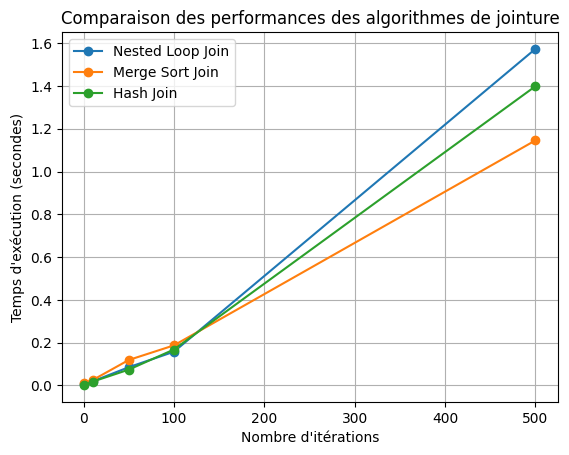

In [35]:
def measure_time(algorithm, file1, file2, category, iterations):
    start_time = time.time()
    for _ in range(iterations):
        algorithm(file1, file2, category)
    end_time = time.time()
    return end_time - start_time

# Tester les temps d'exécution pour chaque algorithme avec différentes itérations
file1 = "quizz_new.json"
file2 = "quizz2_new.json"
category = "Astronomie"
iterations_list = [1, 10, 50,100, 500]  # Différents nombres d'itérations pour observer la variation

nested_loop_times = []
merge_sort_times = []
hash_join_times = []

for iterations in iterations_list:
    nested_loop_times.append(measure_time(filter_and_merge_by_category, file1, file2, category, iterations))
    merge_sort_times.append(measure_time(merge_sort_join, file1, file2, category, iterations))
    hash_join_times.append(measure_time(hash_join, file1, file2, category, iterations))

# Tracer les résultats
plt.plot(iterations_list, nested_loop_times, label="Nested Loop Join", marker='o')
plt.plot(iterations_list, merge_sort_times, label="Merge Sort Join", marker='o')
plt.plot(iterations_list, hash_join_times, label="Hash Join", marker='o')

plt.xlabel("Nombre d'itérations")
plt.ylabel("Temps d'exécution (secondes)")
plt.title("Comparaison des performances des algorithmes de jointure")
plt.legend()
plt.grid()
plt.show()

### Conclusion 
Typiquement, les trois algorithmes de jointure sont censés avoir des performances différentes (résultat clair avec des fichiers volumineux -grand nombre de questions-)
 - Hash join => le plus rapide avec une complexité O(n)
 - Sorted List => une complexité O(nlogn)
 - Nested Loop- Boucle imbriquée => le plus lent O(n²)

# Gestion du canal de chat(Pub-Sub)

## Introduction

Dans le cadre du projet "Quizz Constructif", l'utilisation d'un modèle de publication/souscription (Pub/Sub) est essentielle pour assurer une communication en temps réel entre les utilisateurs et le serveur. Ce modèle permet aux utilisateurs de recevoir instantanément les mises à jour des questions du quizz et d'échanger des messages via le canal de chat. Redis, en tant que base de données en mémoire, offre une excellente prise en charge de cette fonctionnalité.

## Méthodes

Le modèle Pub/Sub de Redis permet de publier des messages sur un canal et de s'abonner à ce canal pour recevoir ces messages. Dans notre application, nous allons utiliser Redis pour gérer les mises à jour des questions du quizz et les messages échangés entre les utilisateurs.

### Étapes de mise en œuvre :

1. **Configuration du serveur Redis**.
2. **Publication des messages** : Lorsqu'une nouvelle question est ajoutée ou qu'un utilisateur envoie un message, il est publié sur le canal approprié.
3. **Abonnement aux messages** : Les utilisateurs s'abonnissent à ce canal pour recevoir les mises à jour.


![](https://blog.containerize.com/fr/introduction-to-redis-pubsub-and-how-does-it-work/images/redis-pub-sub.png)

## Résultats

### Exemple de Code (Pub/Sub sur le canal de l'application)

Voici un exemple de code en Python qui illustre comment utiliser Pub/Sub avec Redis pour notre projet dans le but de publier des indices dans le canal :

<b>Pub : </b>

In [ ]:
import redis
import random
import time

# Connexion à Redis
r = redis.Redis(host='localhost', port=6379)

# Liste d'indices possibles
clue = "Exemple d'indice" 

# Fonction pour publier des indices
def publish_clue(clue):
    # filtrage de l'indice avant qu'il soit publié 
    r.publish('quiz_channel', clue)

for _ in range(100):
    publish_clue(clue)
    print(f"Publié : {clue}")
    time.sleep(1)  


<b>Sub : </b>

In [ ]:
# à executer séparemment
import redis
import threading

# Connexion à Redis
r = redis.Redis(host='localhost', port=6379)
def listen_to_messages():
    pubsub = r.pubsub()
    pubsub.subscribe('quiz_channel')
    
    for message in pubsub.listen():
        if message['type'] == 'message':
            print(f"Nouvelle indice reçue : {message['data'].decode('utf-8')}")

# Démarrer le thread d'écoute
listener_thread = threading.Thread(target=listen_to_messages)
listener_thread.start()


## Discussion

L'utilisation de Pub/Sub dans notre application "Quizz Constructif" présente plusieurs avantages. En permettant aux utilisateurs de recevoir instantanément les nouvelles questions, nous garantissons une expérience interactive et engageante. Ce modèle de communication favorise également l'échange de messages dans le canal de chat, renforçant ainsi la collaboration entre les utilisateurs.

**Serait-il possible d'opter pour MongoDB ?**
 
Si nous tentions d'utiliser MongoDB pour le modèle Pub/Sub, la mise en œuvre serait plus complexe et moins performante. MongoDB ne dispose pas d'un mécanisme de Pub/Sub intégré, ce qui nécessiterait la mise en place de clusters et de réplicats pour garantir une communication en temps réel -comme nous avons vu dans la partie MongiDB précedemment-, en ajoutant des coûts et une complexité de gestion. De plus, MongoDB n’est pas optimisé pour gérer des messages rapides et éphémères en mémoire comme Redis, rendant cette solution moins adaptée pour les échanges en temps réel de notre application.

## Conclusion

En intégrant le modèle Pub/Sub de Redis dans le projet "Quizz Constructif", nous sommes en mesure d'assurer une communication en temps réel efficace entre les utilisateurs et le serveur. Cette approche améliore l'interactivité et la fluidité de l'expérience utilisateur, essentielle pour un quizz en ligne. 


<h1>Recapitulatif</h1>

Ce rapport explore l'importance de la `dénormalisation` et l’utilité des bases de données NoSQL `Redis` et `MongoDB`. Nous avons comparé leurs fonctionnalités clés.

Dans un cas pratique de quiz en temps réel, Redis a été choisi pour ses capacités de réponse rapide, de gestion des notifications en direct, et de suppression automatique des données.

En conclusion, Redis et MongoDB apportent des solutions puissantes pour des applications nécessitant rapidité et adaptabilité des données.

**Ressources :**

- [Bases de Données Avancées - SQL, NoSQL, NewSQL](https://lipn.univ-paris13.fr/~cerin/BD_AVANCEES/SQL_NoSQL_NewSQL.pdf)
- [Comprendre la jointure en bases de données](https://lipn.univ-paris13.fr/~cerin/jointure.pdf)
- [Convertir un fichier CSV en JSON avec Python](https://www.askpython.com/python/examples/convert-csv-to-json)
- [Documentation des commandes Redis](https://redis.io/commands/)
- [Guide de démarrage rapide Redis](https://developer.redis.com/howtos/quick-start)
- [Documentation Redis Pub/Sub](https://redis.io/docs/interact/pubsub/)
- [Utilisation de Pub/Sub avec Redis et Python (StackHero)](https://www.stackhero.io/fr-fr/services/Redis/documentations/Utilisation-avec-Python/Comment-utiliser-Pub-Sub-avec-Redis-et-Python)
- [Redis pour les débutants](https://redis.com/redis-for-dummies/)
- [MongoDB avec Python](https://www.mongodb.com/languages/python)
- [Pub/Sub avec MongoDB](https://www.mongodb.com/blog/post/pubsub-with-mongodb)
- [LPASUR - Université Paris 13](https://lipn.univ-paris13.fr/~cerin/LPASUR/)
- [Image Pub-Sub](https://blog.containerize.com/fr/introduction-to-redis-pubsub-and-how-does-it-work/images/redis-pub-sub.png)
- [Catégorie de questions du quizz](https://storage.googleapis.com/sales.appinst.io/2017/05/quiz-app-screenshot-1.png)
- [Exemple de quizz en temps réel](https://phpscriptsmall.com)
- [Image MongoDB](https://webimages.mongodb.com)
- [Image Redis](https://clarkes.team)
- [Data Structure](https://media.licdn.com/dms/image/v2/D5612AQHvX3Ftp9DLlQ/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1722349221203?e=2147483647&v=beta&t=W1PXm4d6ueeRKqpgg_T0MQAUftcl1D-xEDLWMycyRR4)
- [Redis-cache](https://romankudryashov.com/blog/2021/06/mongodb-redis-rust/images/architecture.png)






<code>Merci !</code>

